### Importing Libraries

In [1]:
from IPython.display import display
import numpy as np
import modin.pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-08-29 09:08:19,464	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.17
Ray version:,2.6.3
Dashboard:,http://127.0.0.1:8265


In [2]:
ray.cluster_resources()

{'object_store_memory': 1793159577.0,
 'CPU': 12.0,
 'node:192.168.1.10': 1.0,
 'node:__internal_head__': 1.0,
 'GPU': 1.0,
 'accelerator_type:G': 1.0,
 'memory': 3586319156.0}

### Load and Display Dataset

In [3]:
def load_dataset (csv_file):
    """Function to return dataframes if filename is given"""
    base_path = os.getcwd()+'/store-sales-time-series-forecasting'
    dataset = pd.read_csv(base_path + '/' + csv_file)
    return dataset

train = load_dataset("train.csv")
test = load_dataset("test.csv")
oil = load_dataset("oil.csv")
stores = load_dataset("stores.csv")
transactions = load_dataset("transactions.csv")
holiday_events = load_dataset("holidays_events.csv")
display(train.head())
display(test.head())

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


### Exploratory Data Analysis (Train.csv)

In [4]:
# **Checking for empty values **
print ("*** train dataset ***")
print(train.isna().sum())
print ("*** test dataset ***")
print(test.isna().sum())

*** train dataset ***
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
*** test dataset ***
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64


#### Changing to date-time format

In [5]:
def datetime(df, col):
    df["date"] = pd.to_datetime(df[col])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["day_of_week"] = df["date"].dt.day_of_week
    df["day_name"] = df["date"].dt.day_name()
    df["quarter"] = df["date"].dt.quarter
    df["is_leap_year"] = df["date"].dt.is_leap_year
    return df
train = datetime(train, "date")
test =  datetime(test, "date")

#display dataset
display(train.head())
display(test.head())

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,day_name,quarter,is_leap_year
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,Tuesday,1,False
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,Tuesday,1,False
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,Tuesday,1,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,Tuesday,1,False
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,Tuesday,1,False


,id,date,store_nbr,family,onpromotion,year,month,day,day_of_week,day_name,quarter,is_leap_year
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16,2,Wednesday,3,False
1,3000889,2017-08-16,1,BABY CARE,0,2017,8,16,2,Wednesday,3,False
2,3000890,2017-08-16,1,BEAUTY,2,2017,8,16,2,Wednesday,3,False
3,3000891,2017-08-16,1,BEVERAGES,20,2017,8,16,2,Wednesday,3,False
4,3000892,2017-08-16,1,BOOKS,0,2017,8,16,2,Wednesday,3,False


In [6]:
train['sales'].sum()

1073644952.2030686

In [7]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'day_name', 'quarter', 'is_leap_year'],
      dtype='object')

In [8]:
train.shape

(3000888, 13)

### Plots

#### Sales & Time

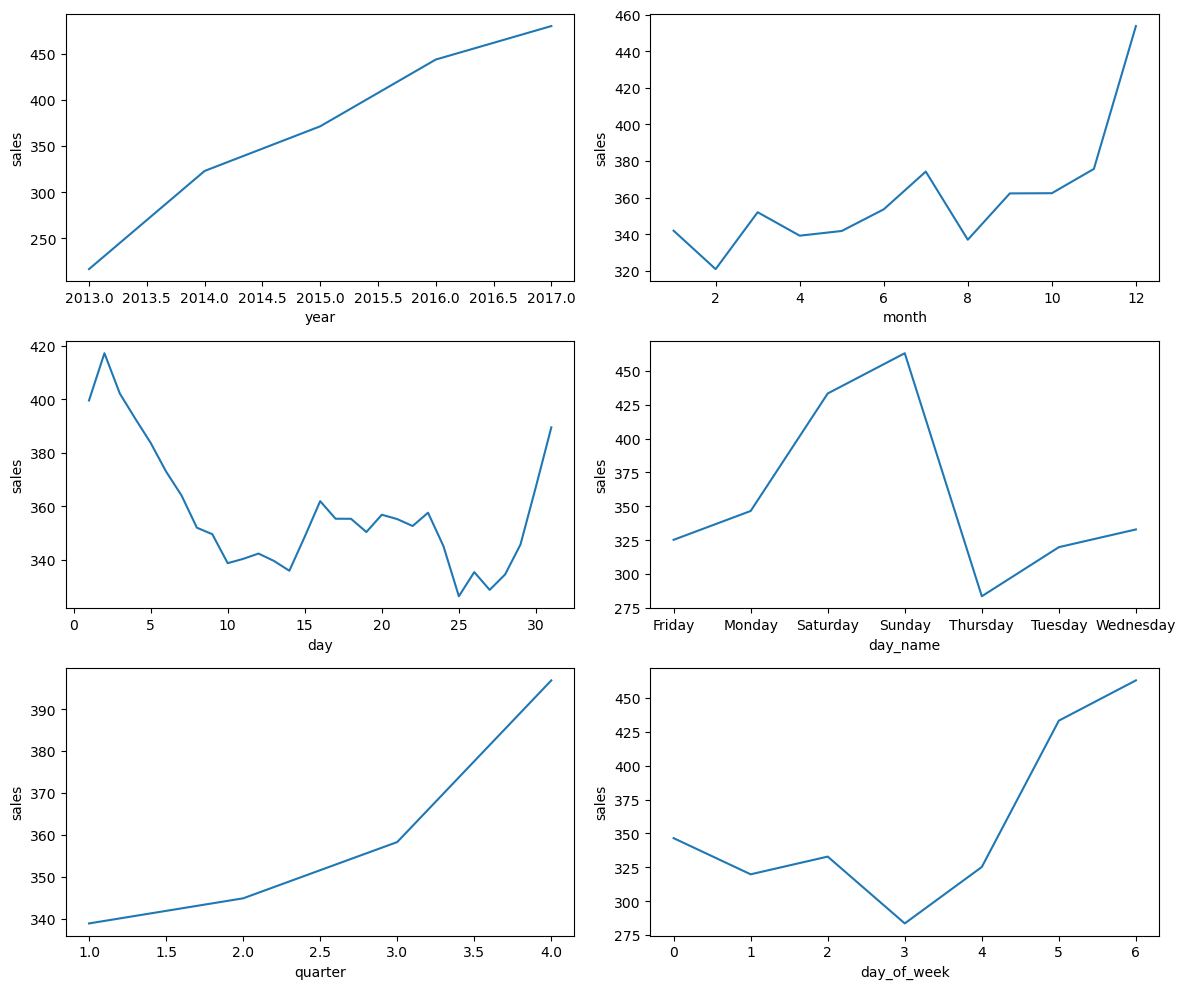

In [9]:
# relation between sales and days
# Average sales per day,week, month & year
grouping_columns = ['year', 'month', 'day', 'day_name', 'quarter', 'day_of_week']

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for ind, column in enumerate(grouping_columns):
    grouped_data = train.groupby(column)['sales'].mean()
    grouped_data = pd.DataFrame(grouped_data).reset_index()
    sns.lineplot(data=grouped_data,  x=column, y='sales', ax=axes[ind])
plt.tight_layout()
plt.show()

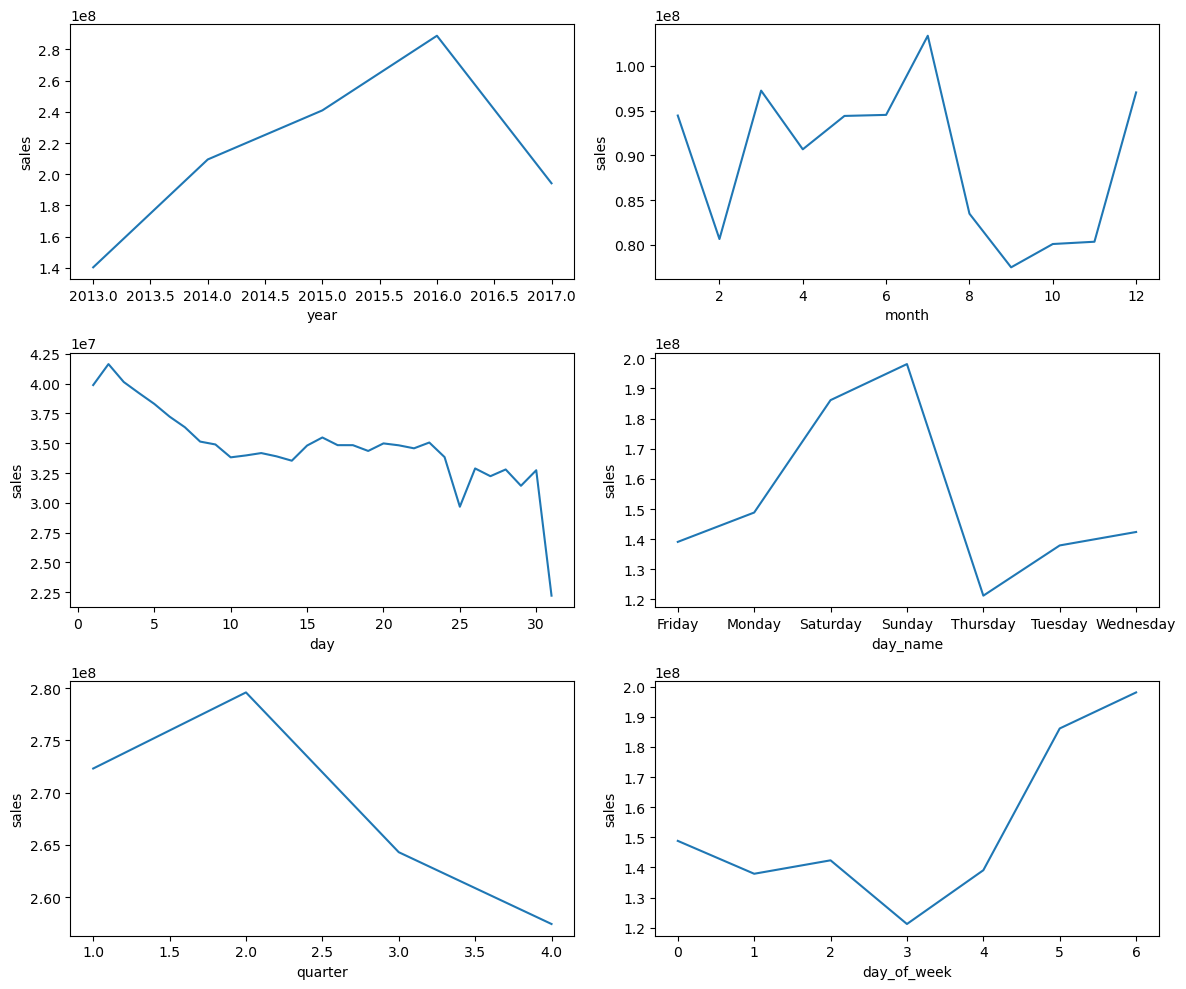

In [10]:
# Total sales per day,week, month & year
grouping_columns = ['year', 'month', 'day', 'day_name', 'quarter', 'day_of_week']

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for ind, column in enumerate(grouping_columns):
    grouped_data = train.groupby(column)['sales'].sum()
    grouped_data = pd.DataFrame(grouped_data).reset_index()
    sns.lineplot(data=grouped_data,  x=column, y='sales', ax=axes[ind])
plt.tight_layout()
plt.show()

#### sales & family (categories)

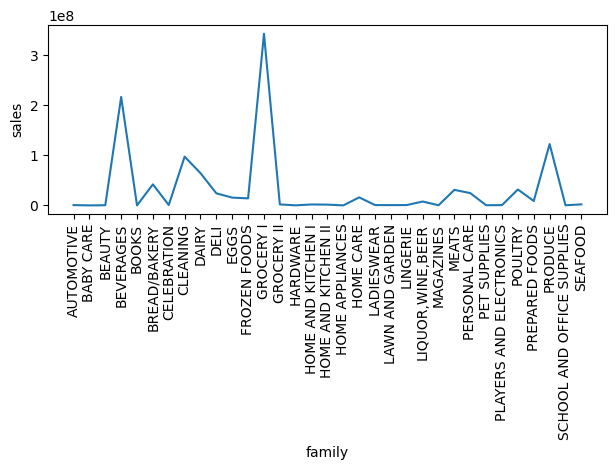

In [11]:
grouped_data = train.groupby('family')['sales'].sum()
grouped_data = pd.DataFrame(grouped_data).reset_index()
sns.lineplot(data=grouped_data,  x='family', y='sales')
plt.xticks(rotation=90)
plt.tight_layout()

#### sales & onpromotion

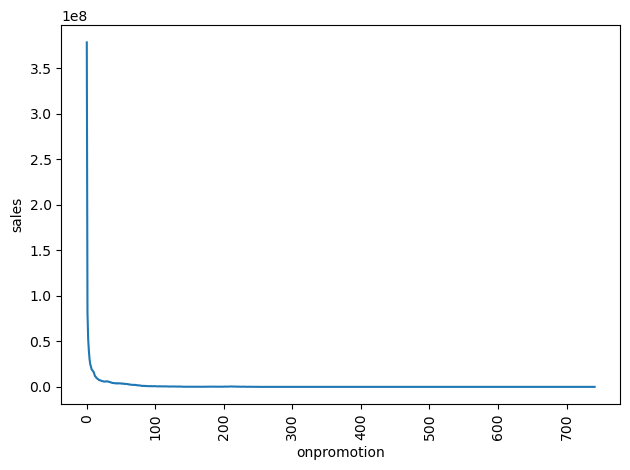

In [12]:
grouped_data = train.groupby('onpromotion')['sales'].sum()
grouped_data = pd.DataFrame(grouped_data).reset_index()
sns.lineplot(data=grouped_data,  x='onpromotion', y='sales')
plt.xticks(rotation=90)
plt.tight_layout()

In [15]:
train['onpromotion'].describe()

count    3.000888e+06
mean     2.602770e+00
std      1.221888e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.410000e+02
Name: onpromotion, dtype: float64

#### violin plot promotion for checking outliers

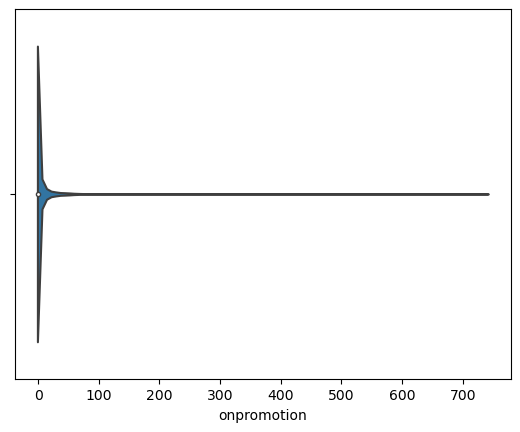

In [16]:
sns.violinplot(x=train["onpromotion"])
plt.show()

### Conclusion

The primary analysis on train.csv gives us the following assumptions:
* Even though the avg sales has increased over year the total sales has not
* Sales mostly happens on weekends, month start & end, 2nd quarter
* Most sales happens in food produxts followed by beauty care products
* doubtfull onpromotion data since mean is close to ~5 but .99 percentile is 700

### Exploratory Data Analysis (stores.csv)

In [17]:
stores.columns

Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')

In [18]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [19]:
# **Checking for empty values **
print ("*** stores dataset ***")
print(stores.isna().sum())

*** stores dataset ***
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


In [20]:
# number of unique values in each column
stores.nunique()

store_nbr    54
city         22
state        16
type          5
cluster      17
dtype: int64

#### Merging stores with train to explore the relation between sales

In [9]:
store_sales = pd.merge(train, stores, on="store_nbr", how ="left")
store_sales.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,day_name,quarter,is_leap_year,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,Tuesday,1,False,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,Tuesday,1,False,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,Tuesday,1,False,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,Tuesday,1,False,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,Tuesday,1,False,Quito,Pichincha,D,13


In [22]:
store_sales.shape

(3000888, 17)

### Plots (Stores_sale)

#### total sales per city

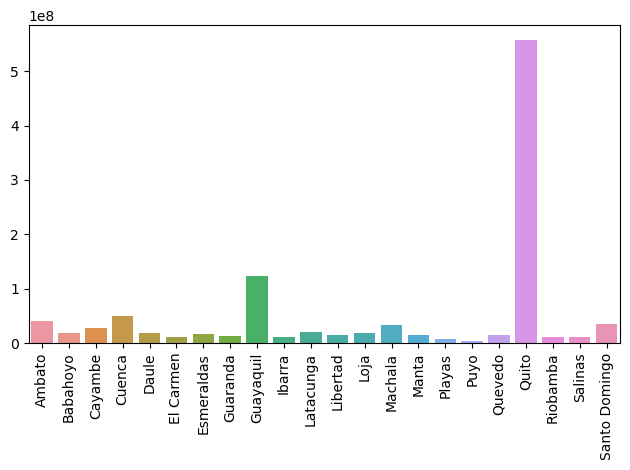

In [23]:
grouped_data = store_sales.groupby('city')['sales'].sum()
grouped_data = pd.DataFrame(grouped_data).reset_index()
sns.barplot(x=grouped_data['city'].values.tolist(), y=grouped_data['sales'].values.tolist())
plt.xticks(rotation=90)
plt.tight_layout()

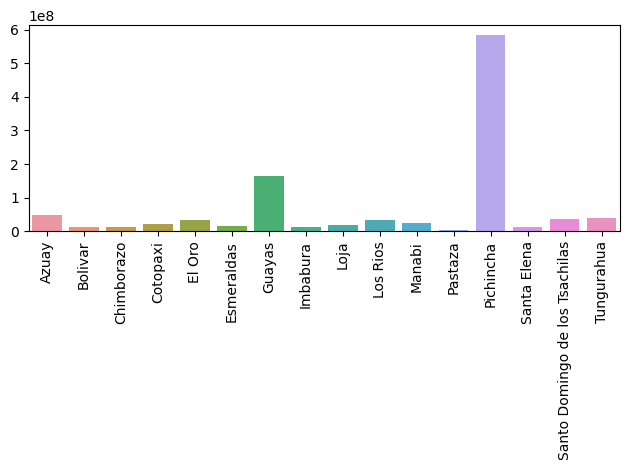

In [24]:
grouped_data = store_sales.groupby('state')['sales'].sum()
grouped_data = pd.DataFrame(grouped_data).reset_index()
sns.barplot(x=grouped_data['state'].values.tolist(), y=grouped_data['sales'].values.tolist())
plt.xticks(rotation=90)
plt.tight_layout()

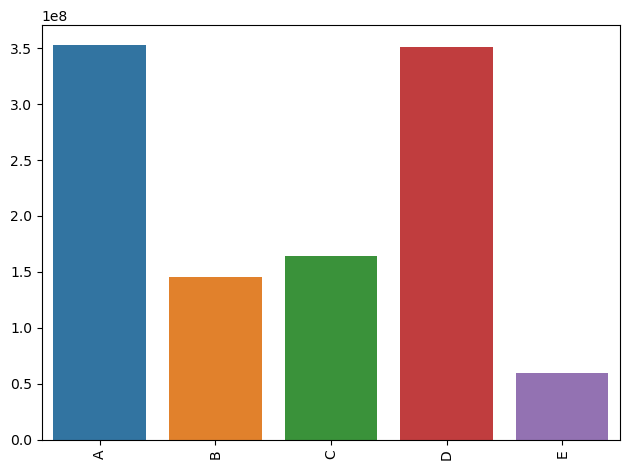

In [25]:
grouped_data = store_sales.groupby('type')['sales'].sum()
grouped_data = pd.DataFrame(grouped_data).reset_index()
sns.barplot(x=grouped_data['type'].values.tolist(), y=grouped_data['sales'].values.tolist())
plt.xticks(rotation=90)
plt.tight_layout()

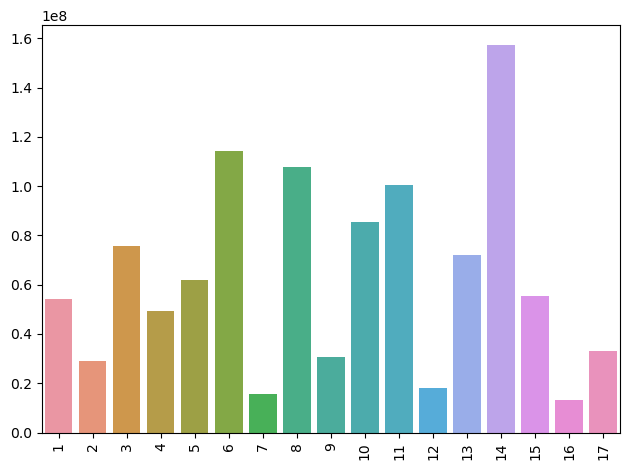

In [26]:
grouped_data = store_sales.groupby('cluster')['sales'].sum()
grouped_data = pd.DataFrame(grouped_data).reset_index()
sns.barplot(x=grouped_data['cluster'].values.tolist(), y=grouped_data['sales'].values.tolist())
plt.xticks(rotation=90)
plt.tight_layout()

### Exploratory Data Analysis (holiday_events.csv)

In [27]:
holiday_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [28]:
# **Checking for empty values **
print ("*** holiday_events dataset ***")
print(holiday_events.isna().sum())

*** holiday_events dataset ***
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64


In [29]:
# number of unique values in each column
holiday_events.nunique()

date           312
type             6
locale           3
locale_name     24
description    103
transferred      2
dtype: int64

#### Merging holiday events with dataset to explore the relation between sales

In [10]:
holiday_events['date'] = pd.to_datetime(holiday_events["date"])
df = pd.merge(store_sales, holiday_events, on="date",how='left')
df.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,...,is_leap_year,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,...,False,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,...,False,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,...,False,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,...,False,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,...,False,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False


In [31]:
df.shape

(3054348, 22)

In [32]:
df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'day_name', 'quarter', 'is_leap_year',
       'city', 'state', 'type_x', 'cluster', 'type_y', 'locale', 'locale_name',
       'description', 'transferred'],
      dtype='object')

In [33]:
df.shape

(3054348, 22)

In [34]:
# **Checking for empty values **
print ("*** complete dataset ***")
print(df.isna().sum())

*** complete dataset ***
id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
year                  0
month                 0
day                   0
day_of_week           0
day_name              0
quarter               0
is_leap_year          0
city                  0
state                 0
type_x                0
cluster               0
type_y          2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64


In [11]:
# number of unique values in each column
df.nunique()

id              3000888
date               1684
store_nbr            54
family               33
sales            379610
onpromotion         362
year                  5
month                12
day                  31
day_of_week           7
day_name              7
quarter               4
is_leap_year          2
city                 22
state                16
type_x                5
cluster              17
type_y                6
locale                3
locale_name          24
description         101
transferred           2
dtype: int64

(raylet) [2023-08-29 09:12:19,472 E 14427 14427] (raylet) node_manager.cc:3084: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 2901943f2c2e4a98e69db4889c58f94777c0e7c9dab3f8e2cc1a8145, IP: 192.168.1.10) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.1.10`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


In [36]:
df['type_y'].value_counts()

Holiday       304722
Event          99792
Additional     67716
Transfer       16038
Work Day        8910
Bridge          5346
Name: type_y, dtype: int64

In [37]:
df['locale'].value_counts()

National    261954
Local       208494
Regional     32076
Name: locale, dtype: int64

### Plot Holiday Sales

#### Plot Based Type of Day

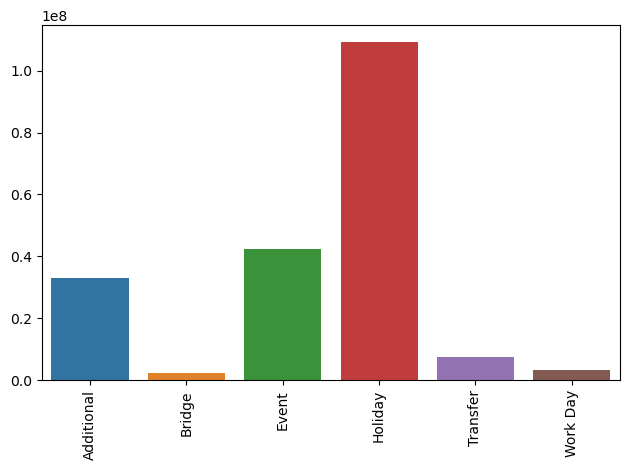

In [40]:
grouped_data = df.groupby('type_y')['sales'].sum()
grouped_data = pd.DataFrame(grouped_data).reset_index()
sns.barplot(x=grouped_data['type_y'].values.tolist(), y=grouped_data['sales'].values.tolist())
plt.xticks(rotation=90)
plt.tight_layout()

#### Plot Based Type of holiday

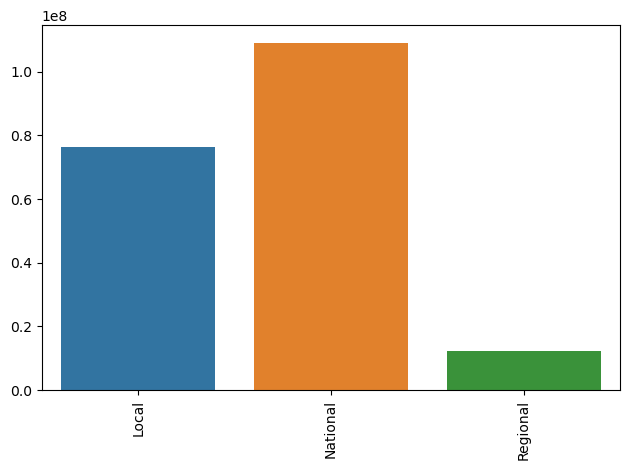

In [41]:
grouped_data = df.groupby('locale')['sales'].sum()
grouped_data = pd.DataFrame(grouped_data).reset_index()
sns.barplot(x=grouped_data['locale'].values.tolist(), y=grouped_data['sales'].values.tolist())
plt.xticks(rotation=90)
plt.tight_layout()

#### Plot Based Type of different holiday

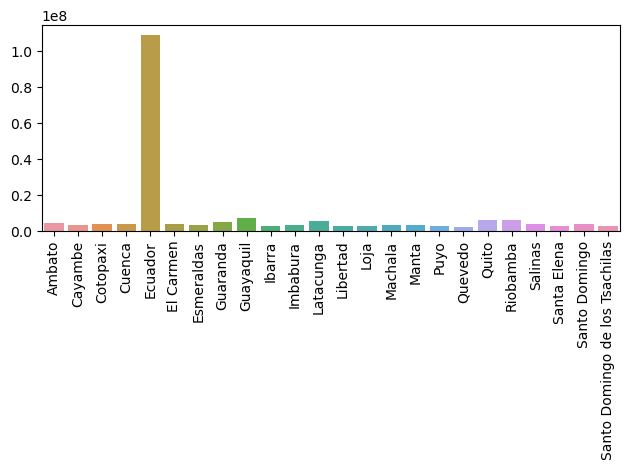

In [42]:
grouped_data = df.groupby('locale_name')['sales'].sum()
grouped_data = pd.DataFrame(grouped_data).reset_index()
sns.barplot(x=grouped_data['locale_name'].values.tolist(), y=grouped_data['sales'].values.tolist())
plt.xticks(rotation=90)
plt.tight_layout()

In [12]:
# category of products with maximum total sales on holidays
df_grp = df.groupby(['type_y','family']).agg({'sales':sum})
df_grp = df_grp['sales'].groupby('type_y', group_keys=False)
df_grp = df_grp.apply(lambda x: x.sort_values(by='sales',ascending=False).head(3))
df_grp

type_y      family   
Additional  GROCERY I    1.067094e+07
            BEVERAGES    6.183568e+06
            PRODUCE      3.931573e+06
Bridge      GROCERY I    7.489641e+05
            BEVERAGES    4.949200e+05
            CLEANING     2.314790e+05
Event       GROCERY I    1.368474e+07
            BEVERAGES    9.077222e+06
            PRODUCE      5.427187e+06
Holiday     GROCERY I    3.534831e+07
            BEVERAGES    2.197353e+07
            PRODUCE      1.222117e+07
Transfer    GROCERY I    2.220565e+06
            BEVERAGES    1.660528e+06
            PRODUCE      1.008022e+06
Work Day    GROCERY I    1.115370e+06
            BEVERAGES    6.493000e+05
            CLEANING     3.453200e+05
Name: sales, dtype: float64

### Feature Engineering

In [13]:
df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'day_name', 'quarter', 'is_leap_year',
       'city', 'state', 'type_x', 'cluster', 'type_y', 'locale', 'locale_name',
       'description', 'transferred'],
      dtype='object')

In [14]:
df.drop(['description'], axis=1)

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,...,quarter,is_leap_year,city,state,type_x,cluster,type_y,locale,locale_name,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,2013,1,1,1,...,1,False,Quito,Pichincha,D,13,Holiday,National,Ecuador,False
1,1,2013-01-01,1,BABY CARE,0.000,0,2013,1,1,1,...,1,False,Quito,Pichincha,D,13,Holiday,National,Ecuador,False
2,2,2013-01-01,1,BEAUTY,0.000,0,2013,1,1,1,...,1,False,Quito,Pichincha,D,13,Holiday,National,Ecuador,False
3,3,2013-01-01,1,BEVERAGES,0.000,0,2013,1,1,1,...,1,False,Quito,Pichincha,D,13,Holiday,National,Ecuador,False
4,4,2013-01-01,1,BOOKS,0.000,0,2013,1,1,1,...,1,False,Quito,Pichincha,D,13,Holiday,National,Ecuador,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,2017,8,15,1,...,3,False,Quito,Pichincha,B,6,Holiday,Local,Riobamba,False
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2017,8,15,1,...,3,False,Quito,Pichincha,B,6,Holiday,Local,Riobamba,False
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,2017,8,15,1,...,3,False,Quito,Pichincha,B,6,Holiday,Local,Riobamba,False
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2017,8,15,1,...,3,False,Quito,Pichincha,B,6,Holiday,Local,Riobamba,False


In [15]:
df = df.fillna(0)
df['transferred'] = df['transferred'].astype(int)

In [16]:
categorical_features = ['family', 'day_name', 'city', 'state', 'type_x', 'transferred', 'locale', 'type_y']

df = pd.get_dummies(df, columns=categorical_features)

df['is_leap_year'] = df['is_leap_year'].astype(int)

In [17]:
df.shape

(3054348, 110)

In [18]:
df.isna().sum()

id                 0
date               0
store_nbr          0
sales              0
onpromotion        0
                  ..
type_y_Bridge      0
type_y_Event       0
type_y_Holiday     0
type_y_Transfer    0
type_y_Work Day    0
Length: 110, dtype: int64

In [19]:
from sklearn.decomposition import PCA


encoded_cities = [
'city_Ambato', 'city_Babahoyo', 'city_Cayambe', 'city_Cuenca',
'city_Daule', 'city_El Carmen', 'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra',
'city_Latacunga', 'city_Libertad', 'city_Loja', 'city_Machala', 'city_Manta', 'city_Playas',
'city_Puyo', 'city_Quevedo', 'city_Quito', 'city_Riobamba', 'city_Salinas', 'city_Santo Domingo',
'state_Azuay', 'state_Bolivar', 'state_Chimborazo', 'state_Cotopaxi', 'state_El Oro', 'state_Esmeraldas',
'state_Guayas', 'state_Imbabura', 'state_Loja', 'state_Los Rios', 'state_Manabi', 'state_Pastaza',
'state_Pichincha', 'state_Santa Elena', 'state_Santo Domingo de los Tsachilas', 'state_Tungurahua'
]

num_components = 5
pca_model = PCA(n_components=num_components)

pca_model.fit(df[encoded_cities])

transformed_data = pca_model.transform(df[encoded_cities])

cols = [f'place_pca_{i}' for i in range(1, 6)]

df.drop(columns = encoded_cities)

df[cols] = transformed_data

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.
(raylet) Spilled 2151 MiB, 293 objects, write throughput 27 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) [2023-08-29 09:15:19,482 E 14427 14427] (raylet) node_manager.cc:3084: 3 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 2901943f2c2e4a98e69db4889c58f94777c0e7c9dab3f8e2cc1a8145, IP: 192.168.1.10) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.1.10`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold`

In [20]:
features = [
'store_nbr', 'onpromotion', 'year', 'month', 'day', 'day_of_week', 'quarter', 'is_leap_year',
'cluster', 'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY', 'family_CELEBRATION', 'family_CLEANING',
'family_DAIRY', 'family_DELI', 'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I', 'family_HOME AND KITCHEN II',
'family_HOME APPLIANCES', 'family_HOME CARE', 'family_LADIESWEAR', 'family_LAWN AND GARDEN',
'family_LINGERIE', 'family_LIQUOR,WINE,BEER', 'family_MAGAZINES', 'family_MEATS',
'family_PERSONAL CARE', 'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS', 'family_POULTRY',
'family_PREPARED FOODS', 'family_PRODUCE', 'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD',
'place_pca_1', 'place_pca_2', 'place_pca_3',
'place_pca_4', 'place_pca_5', 'type_x_A', 'type_x_B', 'type_x_C', 'type_x_D',
'type_x_E', 'transferred_0', 'transferred_1','locale_0', 'locale_Local',
'locale_National', 'locale_Regional', 'type_y_0', 'type_y_Additional',
'type_y_Bridge', 'type_y_Event', 'type_y_Holiday', 'type_y_Transfer', 'type_y_Work Day'
]

In [21]:
target = 'sales'

In [22]:
for col in features:
    if col not in test.columns:
        test[col] = np.nan
test.isna().sum()
test = test.fillna(0)

In [23]:
X_train = df.loc[df['year'] != 2017][features]
X_test = df.loc[df['year'] == 2017][features]
y_train = df.loc[df['year'] != 2017][target]
y_test = df.loc[df['year'] == 2017][target]

(raylet) Spilled 4107 MiB, 550 objects, write throughput 29 MiB/s.


In [24]:
from xgboost import XGBRegressor
# import catboost as cb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error

scaler = StandardScaler()

# model_cb = cb.CatBoostRegressor(verbose=False)
model_xgb = XGBRegressor(verbosity=0)

# pipeline_cb = Pipeline([
#     ('scaler', scaler),
#     ('model_cb', model_cb)
# ])

pipeline_xgb = Pipeline([
    ('scaler', scaler),
    ('model_xgb', model_xgb)
])

# pipeline_cb.fit(X_train, y_train)
pipeline_xgb.fit(X_train, y_train)

# y_pred_cb = pipeline_cb.predict(X_test)
y_pred_xgb = pipeline_xgb.predict(X_test)

y_pred_combined = y_pred_xgb

msle = mean_squared_log_error(abs(y_test), abs(y_pred_combined), squared=False)
print("Mean Squared Log Error:", msle)

ModuleNotFoundError: No module named 'xgboost'